# Notebook "6_Besoin_3_Application_cmb_heuristique"


## Description

Ce notebook se focalise sur l'application de la CMB avec heuristique

## Structure du notebook

Ce notebook est construit de plusieurs parties :
- I. Import des bibliothèques
- II. Chargement des données et des profils
- III. Affichage des résultats

## Prérequis

### Source de données

Pour que le notebook fonctionne, il est nécessaire que le fichier project_config.yml soit situé au même niveau que ce notebook : ce fichier permet la connexion à la source de données.

### Installation des prérequis techniques

Le notebook fonctionne sur Python 3.7 avec les bibliothèques suivantes :
- pandas
- psycopg2
- sqlachemy
- sklearn
- numpy
- yaml
- matplotlib

# I - Import des bibliothèques

In [1]:
# handling postgres database
import psycopg2
import pandas.io.sql as sqlio
import pandas as pd 
from sqlalchemy import create_engine
from io import StringIO
from sklearn.linear_model import Lasso
from sklearn import metrics
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yaml
from IPython.display import clear_output
from datetime import datetime, timedelta

# II - Chargement des données et des profils

In [2]:
Profiles = ['HOA',
    'BBOA',
    'OPOA/OBBOA',
    'BSOA (marine)',
    'BSOA (isoprene)',
    'ASOA (nitro-PAHs)',
    'ASOA (oxy-PAHs)',
    'ASOA (phenolic compounds oxidation)',
    'ASOA (toluene oxidation)',
    'SOA (unknown)']

## II.a Recherche des identifiants de connexion

In [3]:
with open(r'.\project_config.yml') as file:
    dbInfo = yaml.load(file, Loader=yaml.FullLoader)
    HOSTNAME = dbInfo["project-database"]["hostname"]
    DATABASE = dbInfo["project-database"]["name"]
    USER = dbInfo["project-database"]["user"]
    PASSWORD = dbInfo["project-database"]["password"]
    PORT = "5432"

## II.b Recherche des profils

In [4]:
df = pd.read_excel('./pmf_profiles.xlsx', engine='openpyxl')

df.drop(columns=['Unnamed: 0'], inplace=True)
df.rename(columns={'Unnamed: 1': 'amus'}, inplace=True)
df = df[["amus"] + Profiles]
pro = df.columns[1:]

## II.c Récupération des données

In [20]:
## SELECTION DE LA DATE
start_date = '2015-01-01'
end_date = '2016-01-01'

# start_date = '2017-01-01'
# end_date = '2019-01-01'

In [21]:
query = f"""
    SELECT *
    FROM public.regressor_results
    WHERE model = 'LASSO_10_heu' AND date >= '{start_date}' AND date <= '{end_date}'
    ORDER BY date
"""
connection = psycopg2.connect(user = USER, password = PASSWORD, host = HOSTNAME, port = PORT, database = DATABASE)
df_result = sqlio.read_sql_query(query, connection)
connection.close()

In [22]:
list_dates = pd.unique(df_result['date'].values)

presence_list = []
for pro in Profiles:
    result_date = df_result['date'][df_result['profile'] == pro].values
    result = [1 if date in result_date else 0 for date in list_dates]
    presence_list.append(result)

# III. Affichage des résultats

## III.a Présence du profils en fonction du temps

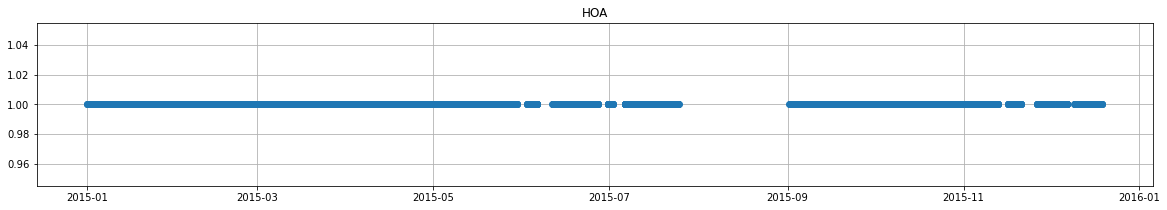

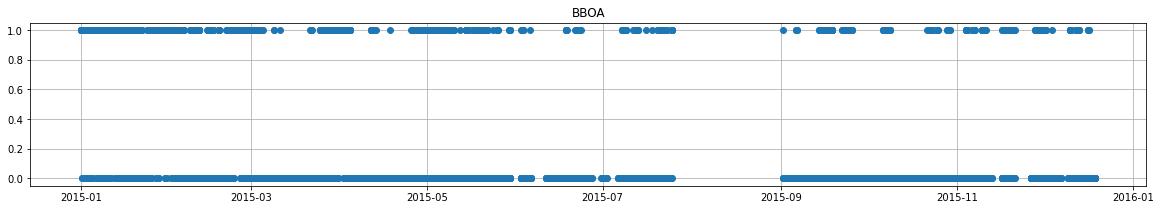

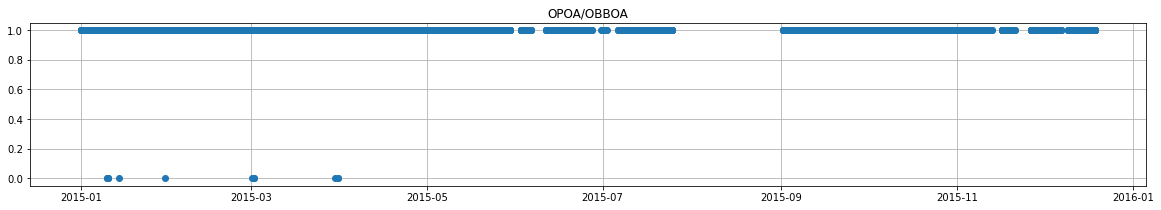

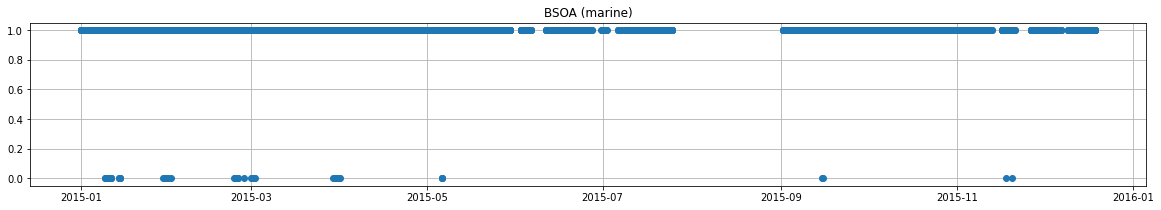

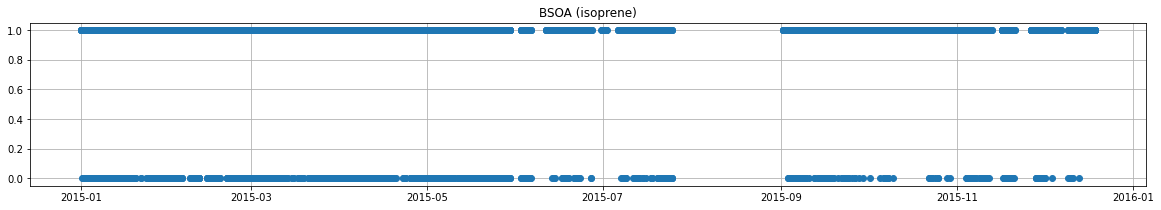

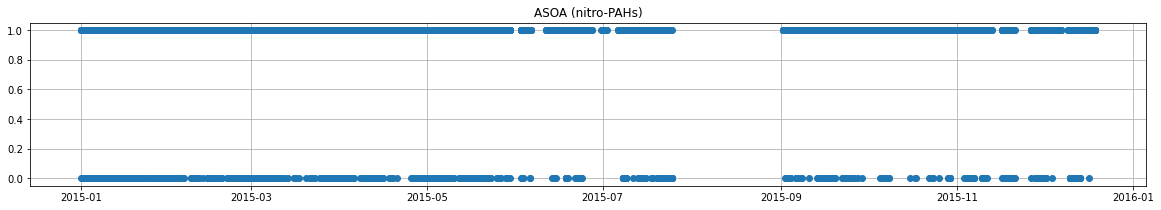

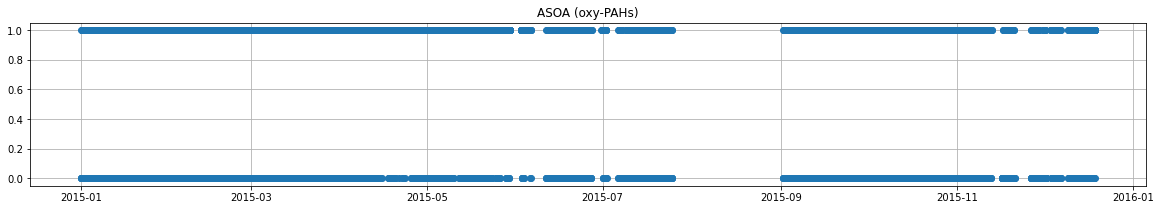

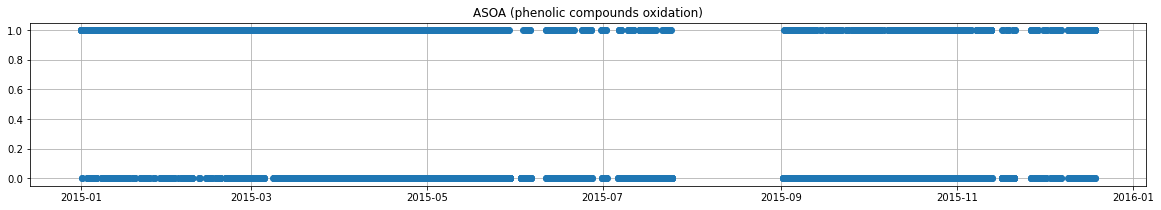

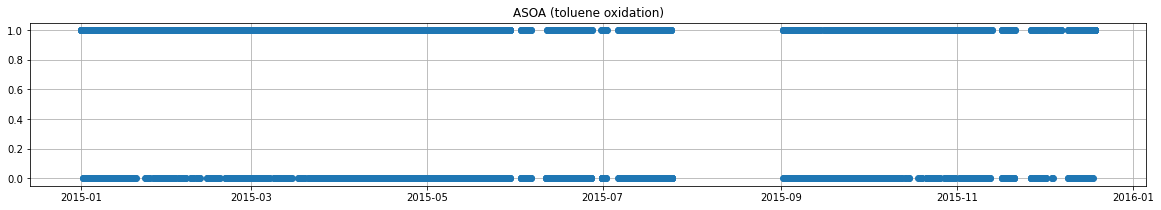

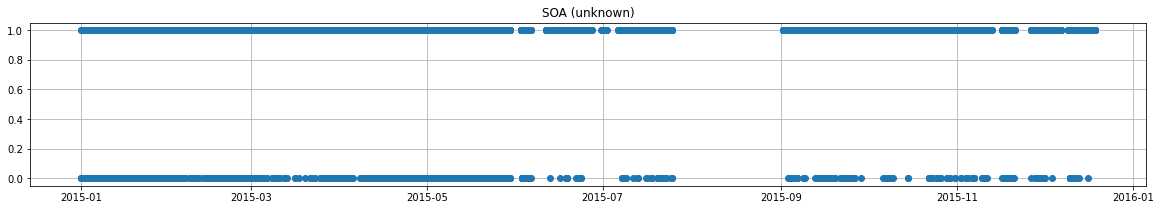

In [23]:
plt.rcParams["figure.figsize"] = (20,3)
for index, pro in enumerate(Profiles):
#     fig.size(7,10)
    plt.title(pro)
    plt.plot(list_dates, presence_list[index], marker='o', linestyle="None")
    plt.grid()
    plt.show()

## III.a Valeurs de pondération en fonction du temps

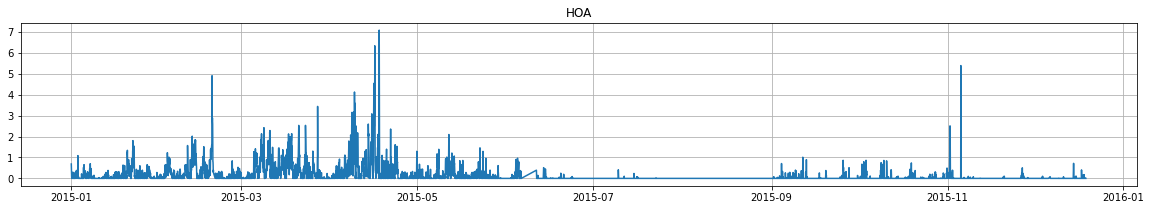

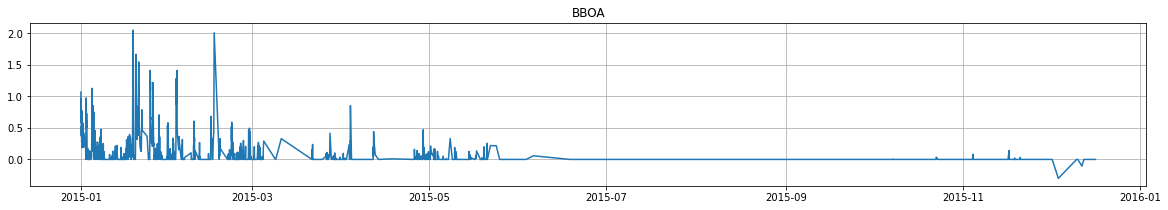

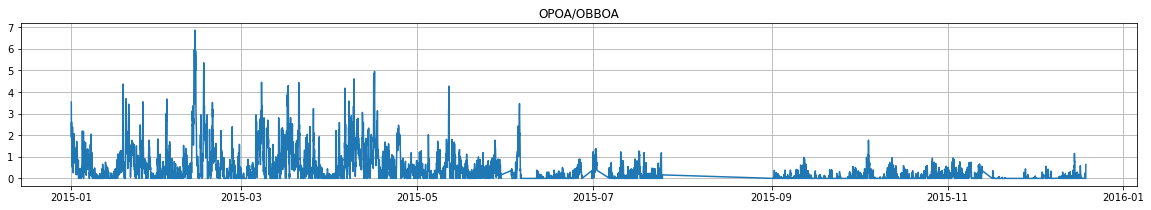

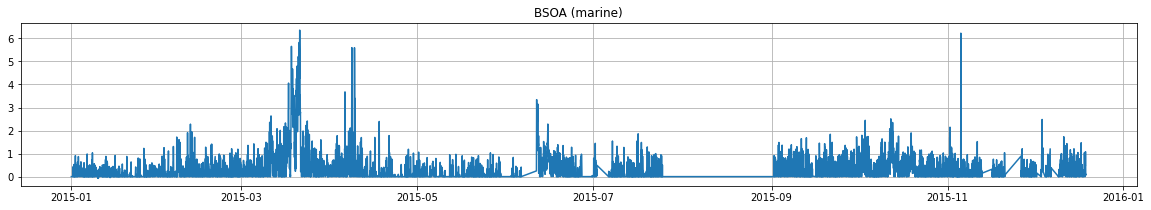

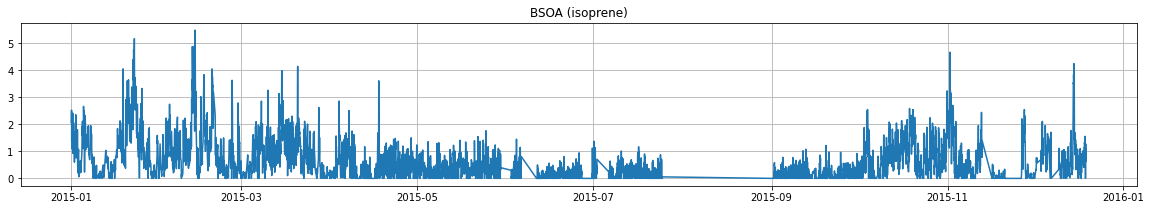

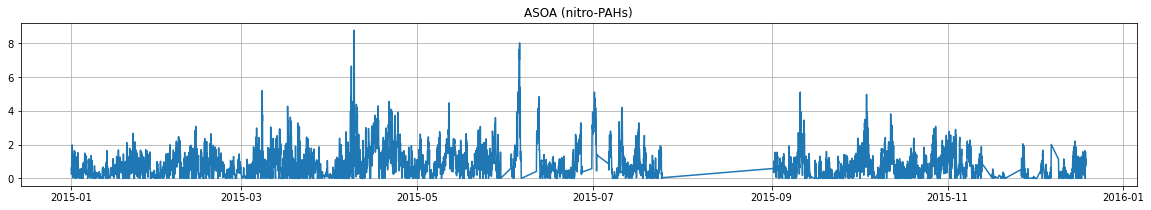

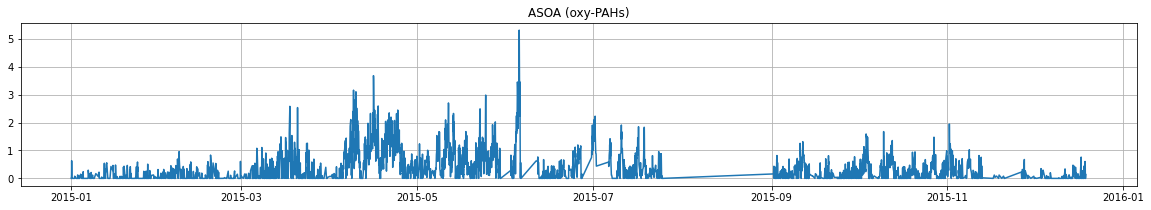

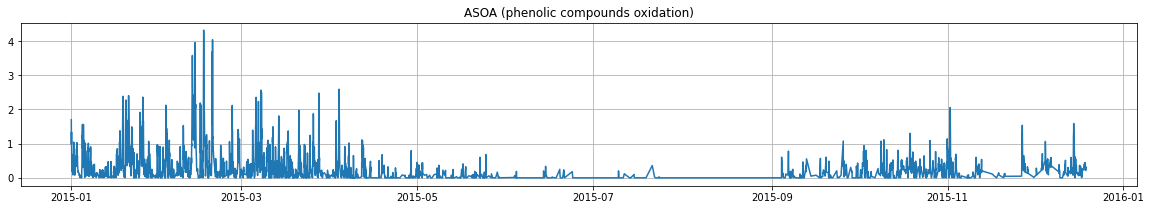

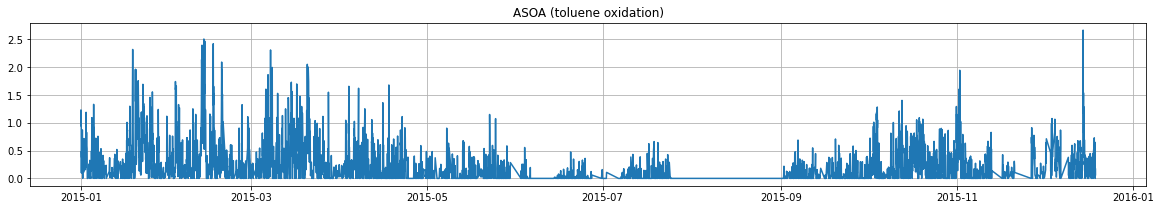

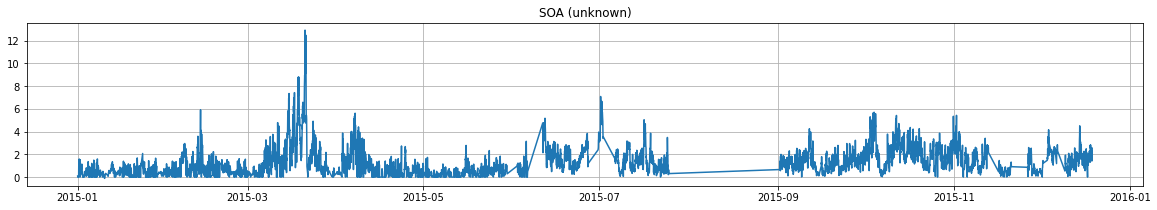

In [24]:
plt.rcParams["figure.figsize"] = (20,3)
for pro in Profiles:
#     fig.size(7,10)
    df_pro = df_result[['date', 'contribution']][df_result['profile'] == pro]
    plt.title(pro)
    plt.plot(df_pro['date'].values, df_pro['contribution'].values)
    plt.grid()
    plt.show()

## III.c Moyenne mobile du nombre de profils en fonction du temps

In [25]:
presence_list = []
for pro in Profiles:
    result_date = df_result['date'][df_result['profile'] == pro].values
    result = [1 if date in result_date else 0 for date in list_dates]
    presence_list.append(result)

In [31]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

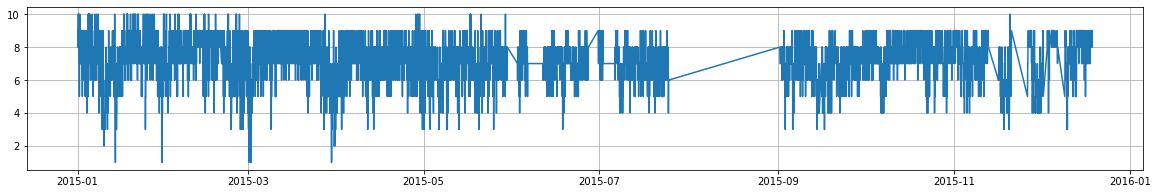

In [35]:
plt.rcParams["figure.figsize"] = (20,3)
mean_profils = np.mean(presence_list, axis = 0) * 10
plt.grid()
plt.plot(list_dates, mean_profils)

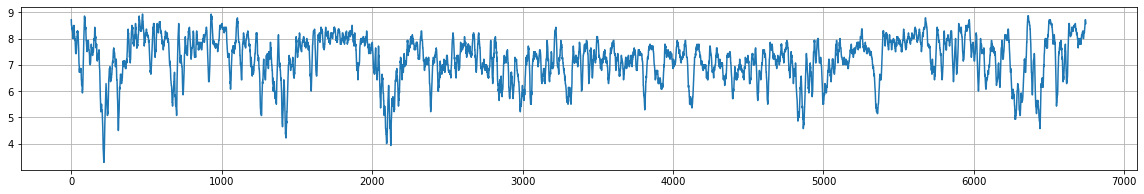

In [39]:
plt.rcParams["figure.figsize"] = (20,3)
mean_profils = np.mean(presence_list, axis = 0) * 10
plt.grid()
plt.plot(moving_average(mean_profils, 14))

In [27]:
query = f"""
    SELECT *
    FROM public.regressor_results
    WHERE model = 'LASSO_10_heu'
    ORDER BY date
"""
connection = psycopg2.connect(user = USER, password = PASSWORD, host = HOSTNAME, port = PORT, database = DATABASE)
df = sqlio.read_sql_query(query, connection)
connection.close()

In [28]:
date = df['date'].unique()
df_final = pd.DataFrame(columns=['date'], data=date)
df_final = df_final.sort_values(by=['date'])
for pro in Profiles:
    aux = df[['date', 'contribution']][df['profile'] == pro]
    df_final = pd.merge(df_final, aux, how='left', on='date')
    df_final = df_final.rename(columns={'contribution' : pro})
df_final.to_csv('cmb_10_heuristic_all_time.csv', sep=';')